# MDP



## Toy Game

[Frozen Lake](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/)

In [ ]:
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.8).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
env = gym.make('FrozenLake-v1')
env.reset()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


0

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

## Define MDP

In [ ]:
class MDP():
    def __init__(self, num_states, num_actions, dynamics_fn):
        self.num_states = num_states
        self.num_actions = num_actions
        # P[s][a] represents a list of possible transistions given state s and a.
        # each transistion is expected as a list/tuple:
        # [prob_next_state, next_state, reward, is_terminal]
        self.P = dynamics_fn
        # sanity checks
        self.__verify()

    def __verify(self):
        assert len(self.P) == self.num_states
        for s in self.P.keys():
             assert len(self.P[s]) == self.num_actions
        for s in self.P.keys():
            for a in self.P[s].keys():
                transitions = self.P[s][a]
                p_sum = sum([t[0] for t in transitions])
                assert p_sum <= 1 and p_sum > 0.99

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
mdp = MDP(env.observation_space.n, env.action_space.n, env.unwrapped.P)

print("Number of states ", mdp.num_states)
print("Number of actions ", mdp.num_actions)

sample_actions = {'Up':0, 'RIGHT':1, "DOWN": 2, "LEFT": 3}
sample_states = [0,11,15]
for s in sample_states:
    for a in sample_actions.keys():
        print(f"Transitions for state {s} and action {a} are\n ", mdp.P[s][sample_actions[a]])

Number of states  16
Number of actions  4
Transitions for state 0 and action Up are
  [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False)]
Transitions for state 0 and action RIGHT are
  [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False)]
Transitions for state 0 and action DOWN are
  [(0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)]
Transitions for state 0 and action LEFT are
  [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False)]
Transitions for state 11 and action Up are
  [(1.0, 11, 0, True)]
Transitions for state 11 and action RIGHT are
  [(1.0, 11, 0, True)]
Transitions for state 11 and action DOWN are
  [(1.0, 11, 0, True)]
Transitions for state 11 and action LEFT are
  [(1.0, 11, 0, True)]
Transitions for state 15 and action Up are
  [(1.0, 15, 

## Implement Agent

### Test Agent

In [ ]:

class RandomDeterministicAgent():
    def __init__(self, mdp, discount_rate=1.0, theta=0.05):
        self.mdp = mdp
        self.value_fn = [0] * self.mdp.num_states
        self.theta = theta
        num_a = self.mdp.num_actions
        num_s = self.mdp.num_states

        # random deterministic policy
        self.policy = []
        for s in range(num_s):
            p_s = [0] * num_a
            random_action = random.randint(0, num_a-1)
            p_s[random_action] = 1
            self.policy.append(p_s)
        self.discount_rate = discount_rate

    def get_action(self, s):
        """
        Using self.policy, return an action for state s.
        Supports stochastic policies.
        """
        current_action_prob_dist = self.policy[s]
        action = np.random.choice(list(range(self.mdp.num_actions)), 1, p=current_action_prob_dist)
        return action[0]


class RandomAgent():
    def __init__(self, mdp, discount_rate=1.0, theta=0.05):
        self.mdp = mdp
        self.value_fn = [0] * self.mdp.num_states
        self.theta = theta
        num_a = self.mdp.num_actions
        num_s = self.mdp.num_states

        # initital: random  policy
        self.policy = []
        for s in range(num_s):
            p_s = np.array([1] * num_a)
            p_s = p_s / 4
            self.policy.append(p_s)
        self.discount_rate = discount_rate

    def get_action(self, s):
        """
        Using self.policy, return an action for state s.
        Supports stochastic policies.
        """
        current_action_prob_dist = self.policy[s]
        action = np.random.choice(list(range(self.mdp.num_actions)), 1, p=current_action_prob_dist)
        return action[0]


### Value agent

In [ ]:
class ValueAgent():
    def __init__(self, mdp, discount_rate=1.0, theta=0.000001):
        self.mdp = mdp
        self.value_fn = [0] * self.mdp.num_states
        self.theta = theta
        num_a = self.mdp.num_actions
        num_s = self.mdp.num_states
        self.discount_rate = discount_rate

        # deterministic policy
        self.policy = []
        for s in range(num_s):
            p_s = [0] * num_a
            random_action = random.randint(0, num_a-1)
            p_s[random_action] = 1
            self.policy.append(p_s)

    def get_action(self, s):
        """
        Using self.policy, return an action for state s.
        Supports stochastic policies.
        """
        # Grab current policy for state
        current_action_prob_dist = self.policy[s]

        # Get best action from policy
        action = np.random.choice( list( range( self.mdp.num_actions ) ),
                                   1, p=current_action_prob_dist )

        # Return best action
        return action[0]

    def evaluate_policy_for_state(self, s, action=None):
        """
        Policy evaluation for state s; action is optional.
        If action is given, it estimates state-action value function q(s,a).
        V_s = \sum{pr_s * (r_s + self.discount_rate * self.value_fn[s'])}
        # [prob_next_state, next_state, reward, is_terminal]
        """
        # Establish q value
        qvalue = 0

        # Loop over transitions for specific state and action
        for transition in self.mdp.P[s][action]:
            # Get probability
            pr_s = transition[0]

            # Get reward
            r = transition[2]

            # Get next state
            ns = transition[1]

            # Calculate V using value function and discount state
            cur_v = pr_s * (r + self.discount_rate * self.value_fn[ns])

            # Add value to Q
            qvalue += cur_v

        # Return the Q
        return qvalue

    def update_policy(self, debug=False):
        """
        Using the current value function, improve the existing policy.
        Returns a boolean indicating whether the policy has changed.
        """
        # Establish return variable
        policy_stable = True

        # Loop over the states in the MDP
        for s in range( self.mdp.num_states ):

            # Get the current best action in the policy
            old_action = np.argmax(self.policy[s])

            # Get the value of each action for the current state
            action_values = [self.evaluate_policy_for_state( s, a ) for \
                             a in range( self.mdp.num_actions )]

            # Get the best action from value list
            best_action = np.argmax(action_values)

            # If the best action isn't the current action
            if old_action != best_action:
                # Policy needs work
                policy_stable = False

            # Zero out the current policy
            new_policy = np.zeros( self.mdp.num_actions )

            # Explicity set the value of the new best action
            new_policy[best_action] = 1

            # Update the policy for current state
            self.policy[s] = new_policy

        # Return whether the policy has changed
        return policy_stable

    def value_iteration(self, debug=False):
        """
        Using policy evaluation for state and policy improvement as subroutines,
        Calculates optimal value function first and extracts optimal policy from it.
        """
        # Loop indefinitely
        while True:

            # Initial delta is zero
            delta = 0

            # Loop over the states in the MDP
            for s in range(self.mdp.num_states):

                # Get the current value for the state
                v = self.value_fn[s]

                # Get the values of all actions for this state
                action_values = [self.evaluate_policy_for_state( s, a ) for a in range( self.mdp.num_actions )]

                # Update the value function
                self.value_fn[s] = max( action_values )

                # New delta is the max of v-q
                delta = max( delta, abs( v - self.value_fn[s] ) )

            # If the delta value is less than theta,
            if delta < self.theta:

                # Break the loop, we found it
                break

        # Update the policy
        self.update_policy()

### Policy Agent

In [ ]:
class PolicyAgent():
    def __init__(self, mdp, discount_rate=1.0, theta=0.000001):
        self.mdp = mdp
        self.value_fn = [0] * self.mdp.num_states
        self.theta = theta
        num_a = self.mdp.num_actions
        num_s = self.mdp.num_states
        self.discount_rate = discount_rate

        # random deterministic policy
        self.policy = []
        for s in range(num_s):
            p_s = [0] * num_a
            random_action = random.randint(0, num_a-1)
            p_s[random_action] = 1
            self.policy.append(p_s)

    def get_action(self, s):
        """
        Using self.policy, return an action for state s.
        Supports stochastic policies.
        """
        # Grab current policy for state
        current_action_prob_dist = self.policy[s]

        # Get best action from policy
        action = np.random.choice( list( range( self.mdp.num_actions ) ),
                                   1, p=current_action_prob_dist )

        # Return best action
        return action[0]

    def evaluate_policy_for_state(self, s, action=None):
        """
        Policy evaluation for state s; action is optional.
        Action is None, it estimates state value function, v(s) = q(s, pi(s)). -> self.get_action(s)
        V_s = \sum{pr_s * (r_s + self.discount_rate * self.value_fn[s])}
        """
        # If evaluating for state,
        if action is None:

            # Get action from state
            action = self.get_action( s )

        # Get transitions from state action pair
        transitions = self.mdp.P[s][action]

        # Initialize value for state
        v_s = 0

        # Loop over transitions
        for prob, next_state, reward, _ in transitions:

            # Update state value using calculated value
            v_s += prob * ( reward + self.discount_rate * self.value_fn[next_state] )

        # Return final value
        return v_s

    def evaluate_policy(self):
        """
        Policy evaluation for all states.
        Uses self.theta to determine stopping distance.
        """
        # Initialize delta at highest possible value
        delta = float(' inf' )

        # While delta is higher than theta
        while delta > self.theta:

            # Reset delta to zero (ensures atleast one loop)
            delta = 0

            # For each state in the MDP
            for s in range(self.mdp.num_states):

                # Get current value for state
                v_old = self.value_fn[s]

                # Update the value function for state
                self.value_fn[s] = self.evaluate_policy_for_state( s )

                # Set the new delta to the max of difference
                delta = max( delta, abs( old - self.value_fn[s] ) )

    def update_policy(self, debug=False):
        """
        Using the current value function, improve the existing policy.
        Returns a boolean indicating whether the policy has changed.
        """
        # Initialize boolean
        policy_stable = True

        # For each state in the MDP
        for s in range(self.mdp.num_states):

            # Get the current policy's best action
            old_action = np.argmax( self.policy[s] )

            # Get the values of all actions for this state
            action_values = [self.evaluate_policy_for_state( s, a ) for \
                             a in range( self.mdp.num_actions )]

            # Get best action from the current state
            best_action = np.argmax( action_values )

            # If the current action is not the best action
            if old_action != best_action:

                # Policy has changed
                policy_stable = False

                # Update the policy with best action
                self.policy[s] = np.eye(self.mdp.num_actions)[best_action]

        # Return boolean
        return policy_stable

    def policy_iteration(self, debug=False):
        """
        Using policy evaluation and policy iteration as subroutines,
        Calculates optimal value function and optimal policy.
        """
        # Initialize boolean
        policy_stable = False

        # While policy is not correct
        while not policy_stable:

            # Evaluate the policy
            self.evaluate_policy()

            # Update the policy
            policy_stable = self.update_policy()

<>:34: DeprecationWarning: invalid escape sequence '\s'


## Play Game

In [ ]:
def run_experiment(env, agent, num_runs=1):
    for _ in range(num_runs):
        tot_reward = [0]
        env.reset()
        observation = 0
        done = False
        reward_per_run = 0
        img = plt.imshow(env.render('rgb_array')) # only call this once
        while not done:
            action = agent.get_action(observation)
            print(observation, action)
            observation, reward, done, info = env.step(action)
            reward_per_run += reward

            screen = env.render(mode='rgb_array')
            plt.imshow(screen)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())


        env.close()
        tot_reward.append(reward_per_run + tot_reward[-1])
    return tot_reward

## Testing test angent

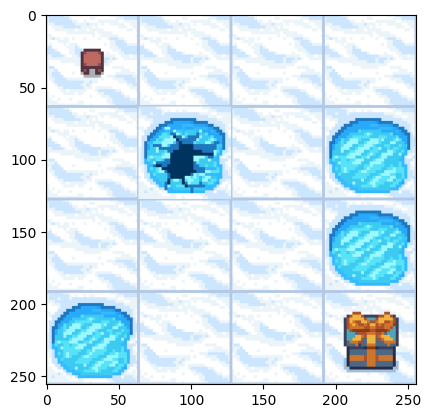

[0, 0.0]

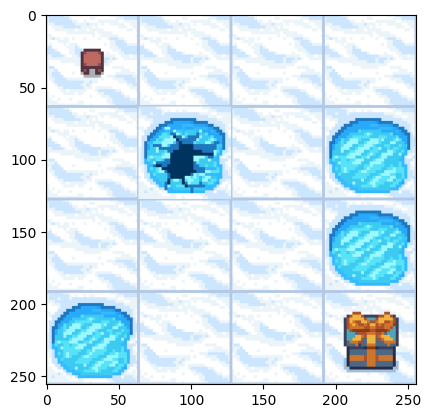

In [ ]:
run_experiment(env, RandomDeterministicAgent(mdp))

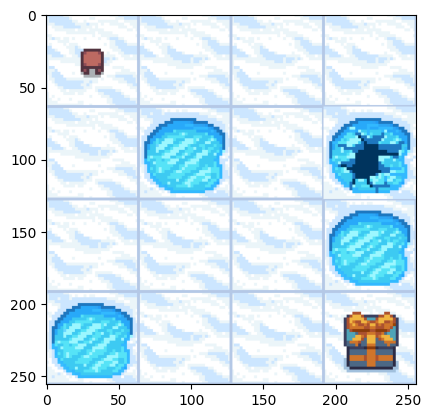

[0, 0.0]

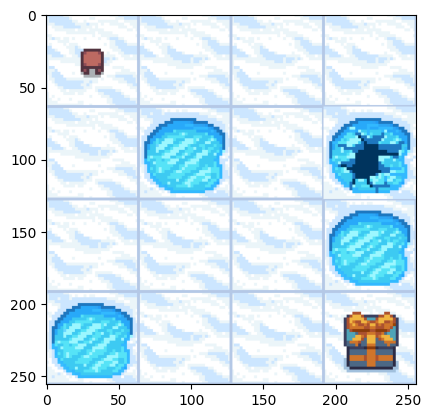

In [ ]:
run_experiment(env, RandomAgent(mdp))

## Testing Value Agent

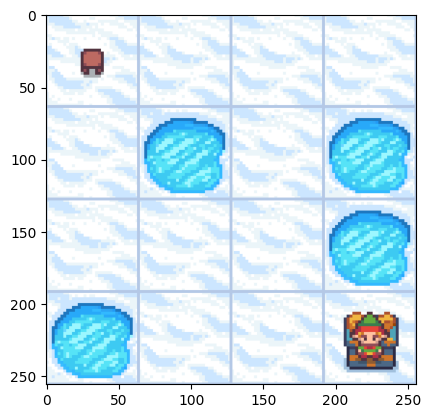

[0, 1.0]

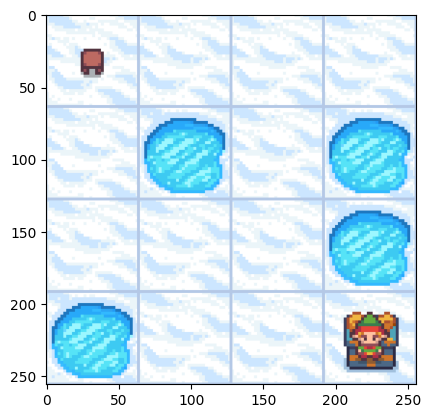

In [ ]:
agent1 = ValueAgent(mdp)
agent1.value_iteration()
run_experiment(env, agent1)

## Testing Policy Agent

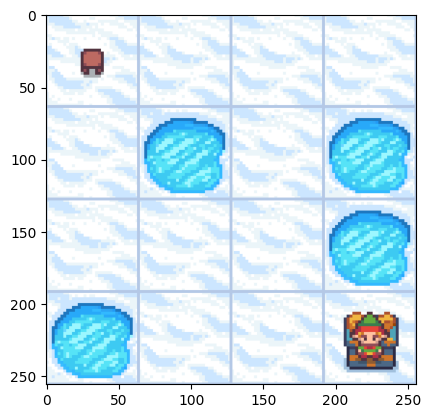

[0, 1.0]

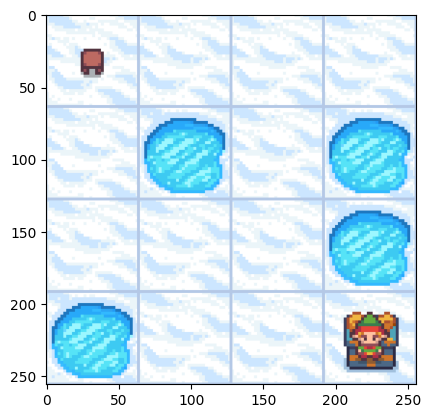

In [ ]:
agent2 = PolicyAgent(mdp)
agent2.policy_iteration()
run_experiment(env, agent2)